# Práctica de PySpark Machine Learning

## 1. Objetivo

Dado el siguente dataset:

https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv

Cuyas variables representan:

* age: edad del beneficiario principal
* sex: género del contratante del seguro, femenino, masculino
* bmi: índice de masa corporal, que proporciona una comprensión del cuerpo, de los pesos que son relativamente altos o bajos en relación con la altura, índice objetivo de peso corporal (kg / m ^ 2) utilizando la relación entre la altura y el peso, idealmente entre 18,5 y 24,9.
* children: número de hijos cubiertos por el seguro de salud / número de dependientes
* smoker: si fuma o no
* region: área de residencia del beneficiario en EE. UU., noreste, sureste, suroeste, noroeste.
* charges: costos médicos individuales facturados por el seguro de salud.


1. Utilizando la API de pandas de PySpark, realiza un EDA del dataset anterior.
2. Luego conviertelós a un DataFrame de Spark normal, realiza las conversiones necesarias para poder hacer machine learning (StringIndexer, StandardScaler, VectorAssembler...) y aplica un modelo de regresión lineal usando pyspark.ml

La variable objetivo a predecir sería **charges**.

## 2. Analytics

### 2.1. Load Libraries

In [1]:
# Install pyspark
!pip install pyspark

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [64]:
# Import libraries for EDA
%matplotlib inline
import pyspark.pandas as ps
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

### 2.2. Load the data

In [3]:
df = ps.read_csv("insurance.csv", sep=",")
df.head(10)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 2.3. Data Quality

Data Quality Analysis phase, ensuring the integrity and usability of data is crucial. Here are the steps that I will follow to check the data quality:

1. Check for Missing Values (Null Data)
* Identify Missing Values: Use functions like isnull() or isna() in pandas to identify missing values.
* Quantify Missing Values: Determine the percentage of missing values in each column to understand the extent of the issue.
* Handle Missing Values: Decide on a strategy to handle missing values, such as: remove or impute missing data.

2. Check for Duplicate Data

* Identify Duplicates: Use functions like duplicated() to find duplicate rows.
* Remove Duplicates: Remove duplicates using drop_duplicates().

3. Check for Inconsistent Data

* Consistency Checks: Ensure that categorical data values are consistent. For example, check for variations in the category names("USA" vs "U.S.A" vs "United States")
* Standardization: Standardize categorical variables to a consistent format.

4. Check for Outliers
* Identify Outliers: Use visualizations (box plots, scatter plots) and statistical methods (Z-score, IQR) to detect outliers.
* Handle Outliers: Decide whether to remove, transform, or keep outliers based on their impact on the analysis.

#### 2.3.1. Check for Null Data

In [49]:
print(df.isna().sum().sort_values(ascending=False))

df.info()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int32  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int32  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int32(2), object(3)

Conclusions:
* There are not any null data.

#### 2.3.2. Check for Duplicate Data

In [50]:
ps.options.compute.ops_on_diff_frames = True

df[df.duplicated() == True]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


Conclusions:
* There are not any duplicated registers.

#### 2.3.3. Check for Inconsistent data

In [51]:
categorical_data = df.select_dtypes("O")
numerical_data = df.select_dtypes("number")

for col in categorical_data.columns:
    print(col)
    print(categorical_data[col].unique())
    print("*********************************************************")

sex
0    female
1      male
Name: sex, dtype: object
*********************************************************
smoker
0     no
1    yes
Name: smoker, dtype: object
*********************************************************
region
0    northwest
1    southeast
2    northeast
3    southwest
Name: region, dtype: object
*********************************************************


Conclusions:
* It seems the categorical data is correct and there are not any inconsistency.

#### 2.3.4. Check for outliers

In [52]:
def outlier_detection(data, features):
    """
    Takes a dataframe and a list of the columns that is decided to apply Tukey´s method for detecting outliers.
    Returns a list of indices that are considered outliers.
    """
    outlier_indices = []
    n = 2 # treshold

    # Iterate over each feature
    for col in features:
        # Calculate quartiles
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # Determine the index of the outliers for feature col
        outlier_list_col = data[(data[col] < Q1 - 1.5 * IQR) | (data[col] > Q3 + 1.5 * IQR)].index

        # Append indices of outliers for every col
        outlier_indices.extend(outlier_list_col)

    # Count occurrences of each index
    outlier_count = Counter(outlier_indices)

    # Select indices with more than n outliers
    multiple_outliers = [index for index, count in outlier_count.items() if count > n]

    return multiple_outliers

In [53]:
outliers_to_drop = outlier_detection(numerical_data, numerical_data.columns)
print(outliers_to_drop)

[]


Conclusions:
- There are not any outliers due to Tukey´s outliers detection method.

### 2.4. EDA Categorical Data

In [67]:
categorical_data.columns

Index(['sex', 'smoker', 'region'], dtype='object')

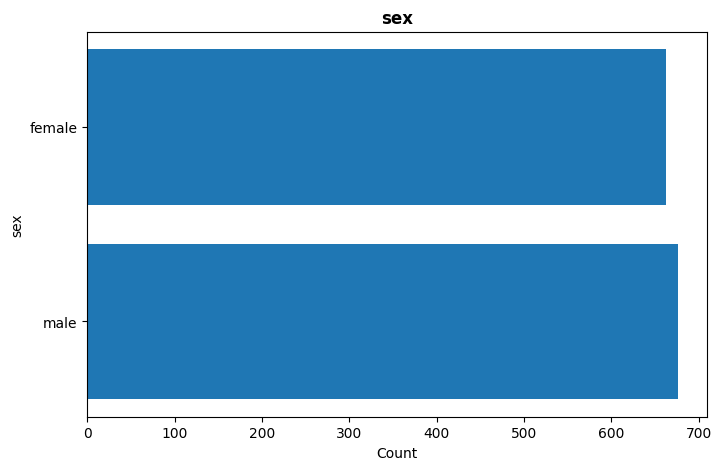

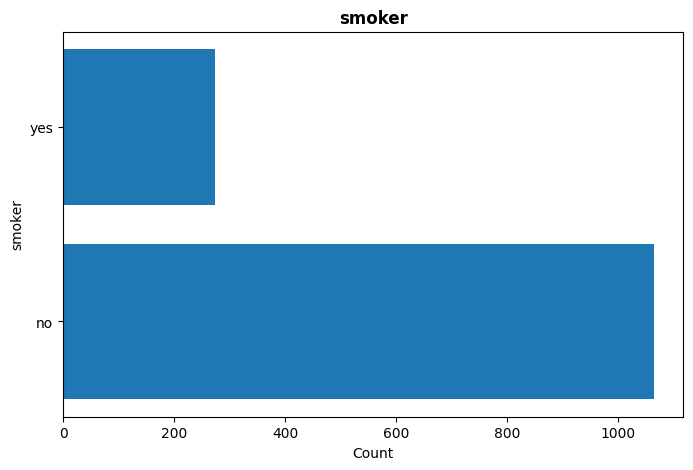

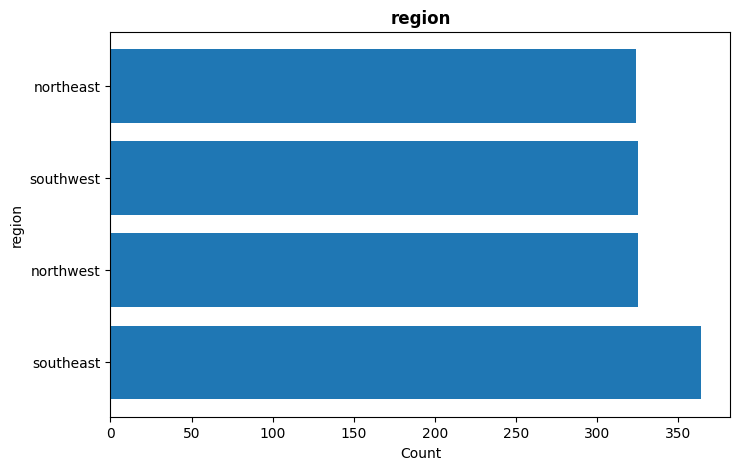

In [83]:
from pyspark.pandas.utils import PandasAPIOnSparkAdviceWarning
# Suppress specific warnings
warnings.filterwarnings("ignore", category=PandasAPIOnSparkAdviceWarning)
warnings.filterwarnings("ignore", category=UserWarning)


for col in categorical_data.columns:
    plt.figure(figsize=(8, 5))
    value_counts = categorical_data[col].value_counts()
    plt.barh(value_counts.index.tolist(), value_counts.values.tolist())  # Convert to list
    plt.title(col, fontsize=12, fontweight="bold")
    plt.xlabel('Count', fontsize=10)
    plt.ylabel(col, fontsize=10)
    plt.show()
    plt.close()